In [1]:
# !pip install nibabel
# !pip install medpy
# !pip install tensorboard
# !pip install --upgrade tensorboard
# !pip install --upgrade torch

In [2]:
import os
from os import listdir
from os.path import isfile, join
import time
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import nibabel as nib
from medpy.io import load
import random

%matplotlib inline

## utils

In [3]:
def mpl_image_grid(images):
    """
    Create an image grid from an array of images. Show up to 16 images in one figure

    Arguments:
        image {Torch tensor} -- NxWxH array of images

    Returns:
        Matplotlib figure
    """
    # Create a figure to contain the plot.
    n = min(images.shape[0], 16) # no more than 16 thumbnails
    rows = 4
    cols = (n // 4) + (1 if (n % 4) != 0 else 0)
    figure = plt.figure(figsize=(2*rows, 2*cols))
    plt.subplots_adjust(0, 0, 1, 1, 0.001, 0.001)
    for i in range(n):
        # Start next subplot.
        plt.subplot(cols, rows, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if images.shape[1] == 3:
            # this is specifically for 3 softmax'd classes with 0 being bg
            # We are building a probability map from our three classes using 
            # fractional probabilities contained in the mask
            vol = images[i].detach().numpy()
            img = [[[(1-vol[0,x,y])*vol[1,x,y], (1-vol[0,x,y])*vol[2,x,y], 0] \
                            for y in range(vol.shape[2])] \
                            for x in range(vol.shape[1])]
            plt.imshow(img)
        else: # plotting only 1st channel
            plt.imshow((images[i, 0]*255).int(), cmap= "gray")

    return figure

def log_to_tensorboard(writer, loss, data, target, prediction_softmax, prediction, counter):
    """Logs data to Tensorboard

    Arguments:
        writer {SummaryWriter} -- PyTorch Tensorboard wrapper to use for logging
        loss {float} -- loss
        data {tensor} -- image data
        target {tensor} -- ground truth label
        prediction_softmax {tensor} -- softmax'd prediction
        prediction {tensor} -- raw prediction (to be used in argmax)
        counter {int} -- batch and epoch counter
    """
    writer.add_scalar("Loss",\
                    loss, counter)
    writer.add_figure("Image Data",\
        mpl_image_grid(data.float().cpu()), global_step=counter)
    writer.add_figure("Mask",\
        mpl_image_grid(target.float().cpu()), global_step=counter)
    writer.add_figure("Probability map",\
        mpl_image_grid(prediction_softmax.cpu()), global_step=counter)
    writer.add_figure("Prediction",\
        mpl_image_grid(torch.argmax(prediction.cpu(), dim=1, keepdim=True)), global_step=counter)

def save_numpy_as_image(arr, path):
    """
    This saves image (2D array) as a file using matplotlib

    Arguments:
        arr {array} -- 2D array of pixels
        path {string} -- path to file
    """
    plt.imshow(arr, cmap="gray") #Needs to be in row,col order
    plt.savefig(path)

def med_reshape(image, new_shape):
    """
    This function reshapes 3D data to new dimension padding with zeros
    and leaving the content in the top-left corner

    Arguments:
        image {array} -- 3D array of pixel data
        new_shape {3-tuple} -- expected output shape

    Returns:
        3D array of desired shape, padded with zeroes
    """

    reshaped_image = np.zeros(new_shape)
    x, y, z = image.shape
    reshaped_image[:x, :y, :z] = image

    return reshaped_image

## volume_stats

In [4]:
def Dice3d(a, b):
    """
    This will compute the Dice Similarity coefficient for two 3-dimensional volumes
    Volumes are expected to be of the same size. We are expecting binary masks -
    0's are treated as background and anything else is counted as data

    Arguments:
        a {Numpy array} -- 3D array with first volume
        b {Numpy array} -- 3D array with second volume

    Returns:
        float
    """
    if len(a.shape) != 3 or len(b.shape) != 3:
        raise Exception(f"Expecting 3 dimensional inputs, got {a.shape} and {b.shape}")

    if a.shape != b.shape:
        raise Exception(f"Expecting inputs of the same shape, got {a.shape} and {b.shape}")

    intersection = np.sum((a>0) * (b>0))
    volumes = np.sum(a>0) + np.sum(b>0)

    if volumes == 0:
        return -1

    return 2.*float(intersection) / float(volumes)

def Jaccard3d(a, b):
    """
    This will compute the Jaccard Similarity coefficient for two 3-dimensional volumes
    Volumes are expected to be of the same size. We are expecting binary masks - 
    0's are treated as background and anything else is counted as data

    Arguments:
        a {Numpy array} -- 3D array with first volume
        b {Numpy array} -- 3D array with second volume

    Returns:
        float
    """
    if len(a.shape) != 3 or len(b.shape) != 3:
        raise Exception(f"Expecting 3 dimensional inputs, got {a.shape} and {b.shape}")

    if a.shape != b.shape:
        raise Exception(f"Expecting inputs of the same shape, got {a.shape} and {b.shape}")
        
    intersection = np.sum((a>0) * (b>0))
    union = np.sum(((a>0) + (b>0))>0)
    
    if union == 0:
        return -1
    
    return float(intersection) / float(union)

## HippocampusDatasetLoader

In [5]:
def LoadHippocampusData(root_dir, y_shape, z_shape):
    '''
    This function loads our dataset form disk into memory,
    reshaping output to common size

    Arguments:
        volume {Numpy array} -- 3D array representing the volume

    Returns:
        Array of dictionaries with data stored in seg and image fields as 
        Numpy arrays of shape [AXIAL_WIDTH, Y_SHAPE, Z_SHAPE]
    '''

    image_dir = join(root_dir, 'images')
    label_dir = join(root_dir, 'labels')

    images = [f for f in listdir(image_dir) if (
        isfile(join(image_dir, f)) and f[0] != ".")]

    out = []
    for f in images:
        image, _ = load(join(image_dir, f))
        label, _ = load(join(label_dir, f))

        # normalize all images (but not labels) so that values are in [0..1] range
        image = image / np.max(image)

        # reshape data since CNN tensors need to be of the same size.
        # since I will feed individual slices to the CNN, I only need to extend 2 dimensions (coronal and sagittal) out of 3 
        image = med_reshape(image, new_shape=(image.shape[0], y_shape, z_shape))
        
        # cast label to int to get distinct class of labels 
        label = med_reshape(label, new_shape=(label.shape[0], y_shape, z_shape)).astype(int)
        
        out.append({"image": image, "seg": label, "filename": f})

    # Hippocampus dataset only takes about 300 Mb RAM, so we can afford to keep it all in RAM
    print(f"Processed {len(out)} files, total {sum([x['image'].shape[0] for x in out])} slices")
    return np.array(out)

In [6]:
root_dir = r"../data"
patch_size = 64
data = LoadHippocampusData(root_dir, y_shape = patch_size, z_shape = patch_size)

Processed 260 files, total 9198 slices


In [7]:
image_4 = data[4]['image']
seg_4 = data[4]['seg']
image_5 = data[5]['image']
seg_5 = data[5]['seg']
image_4.shape, seg_4.shape, image_5.shape, seg_5.shape

((34, 64, 64), (34, 64, 64), (34, 64, 64), (34, 64, 64))

In [8]:
Dice3d(data[4]['seg'], data[5]['seg']), Jaccard3d(data[4]['seg'], data[5]['seg'])

(0.5373763580347009, 0.3674057649667406)

In [9]:
def display_volume_slices(img, w, h):
    plot_w = w
    plot_h = h

    # You can play with figsize parameter to adjust how large the images are
    fig, ax = plt.subplots(plot_h, plot_w, figsize=[35,25])

    for i in range(plot_w*plot_h):
        plt_x = i % plot_w
        plt_y = i // plot_w
        if (i < len(img)):
            ax[plt_y, plt_x].set_title(f"slice {i}")
            ax[plt_y, plt_x].imshow(img[i, :, :], cmap='gray')
        ax[plt_y, plt_x].axis("off")

    plt.show()

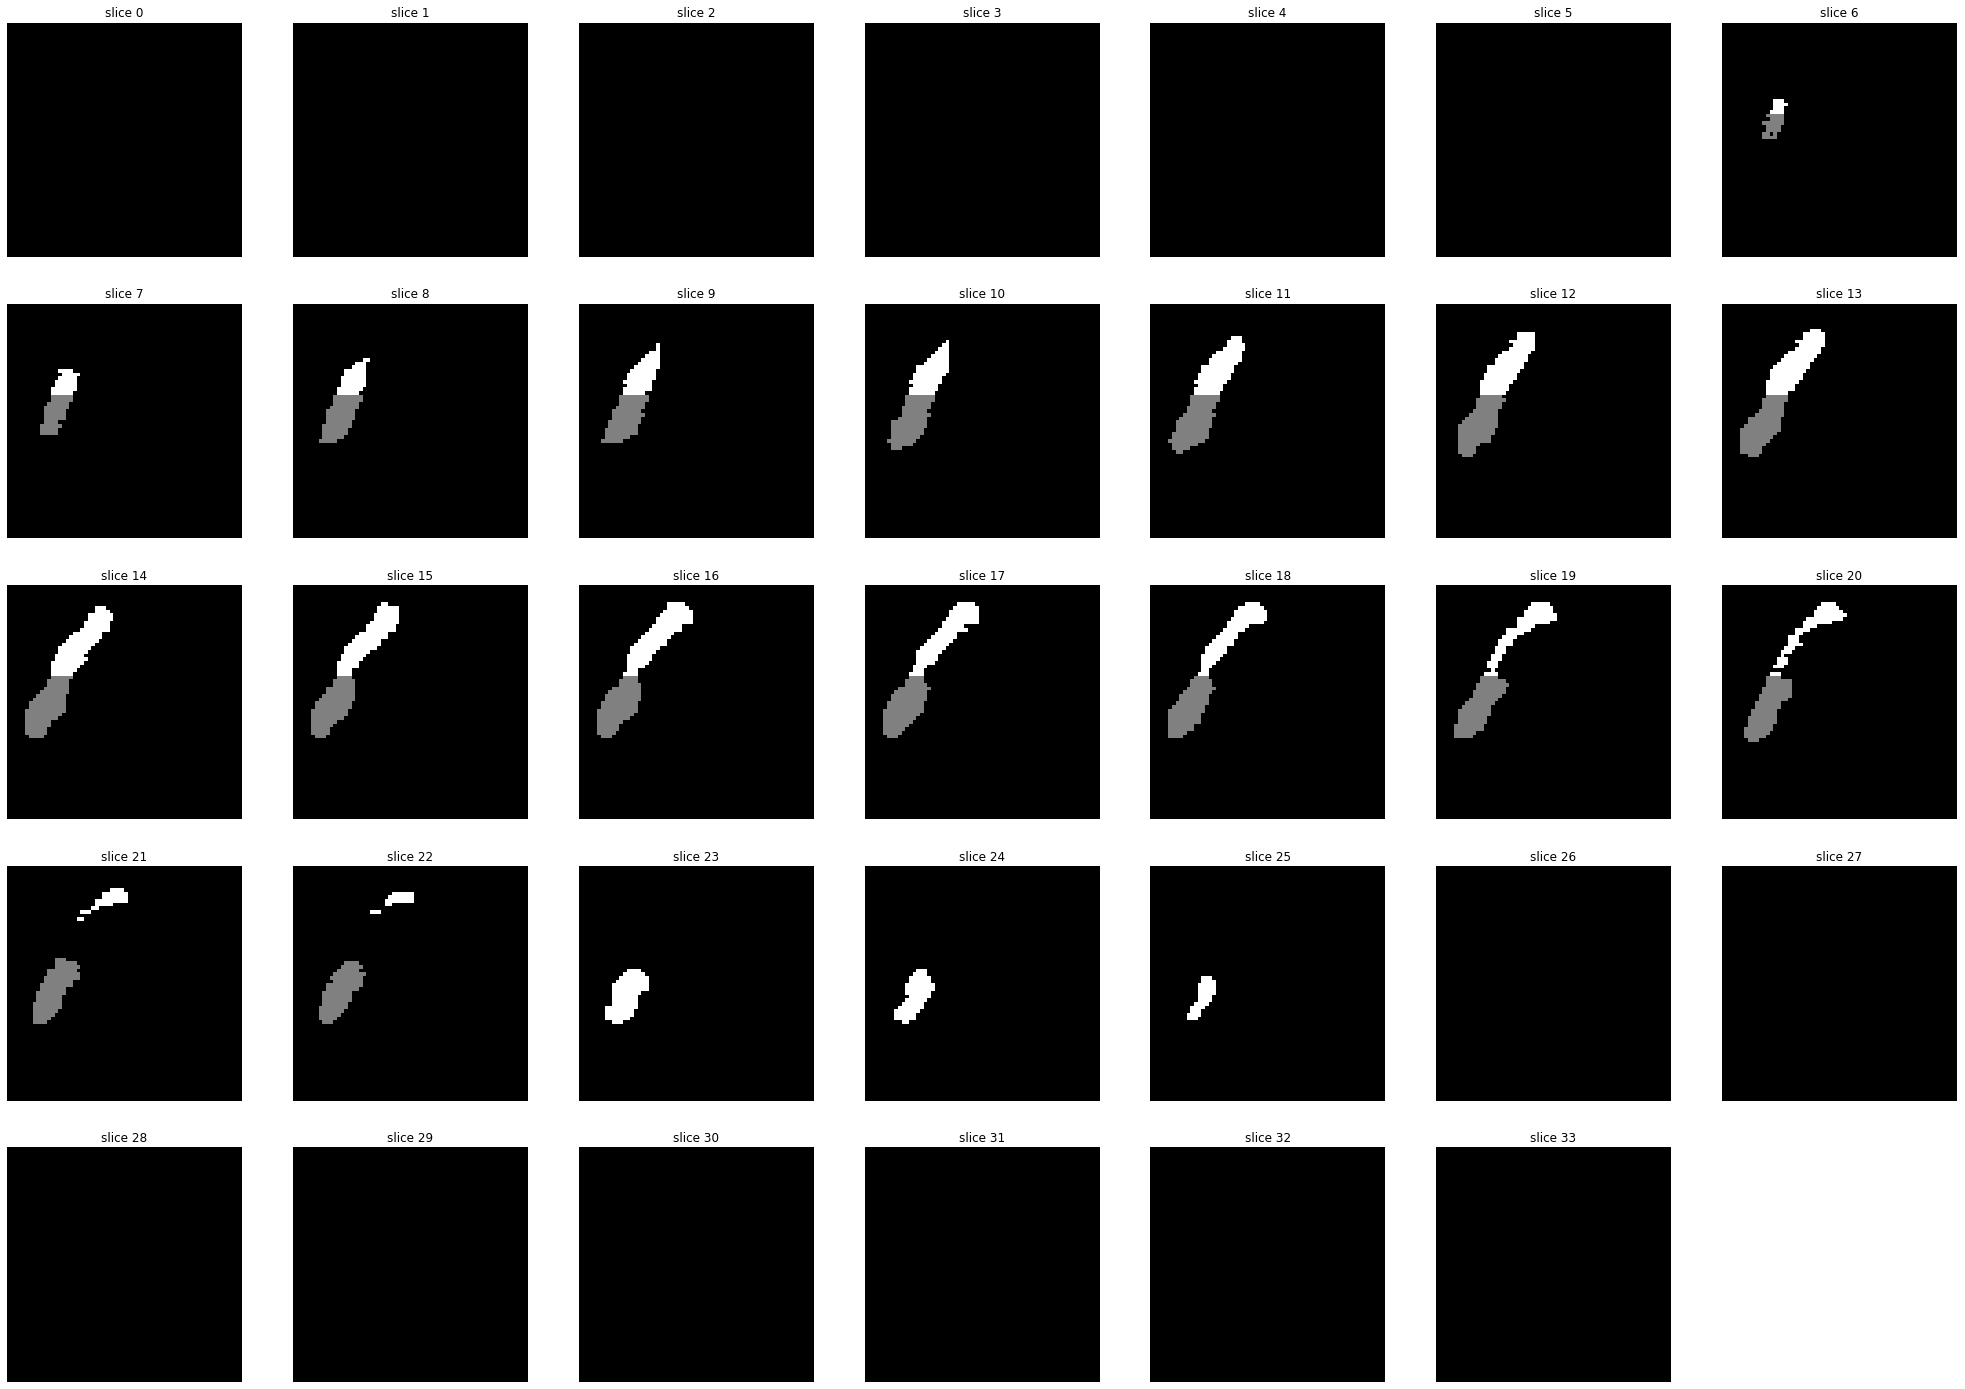

In [10]:
display_volume_slices(seg_4, 7, 5)

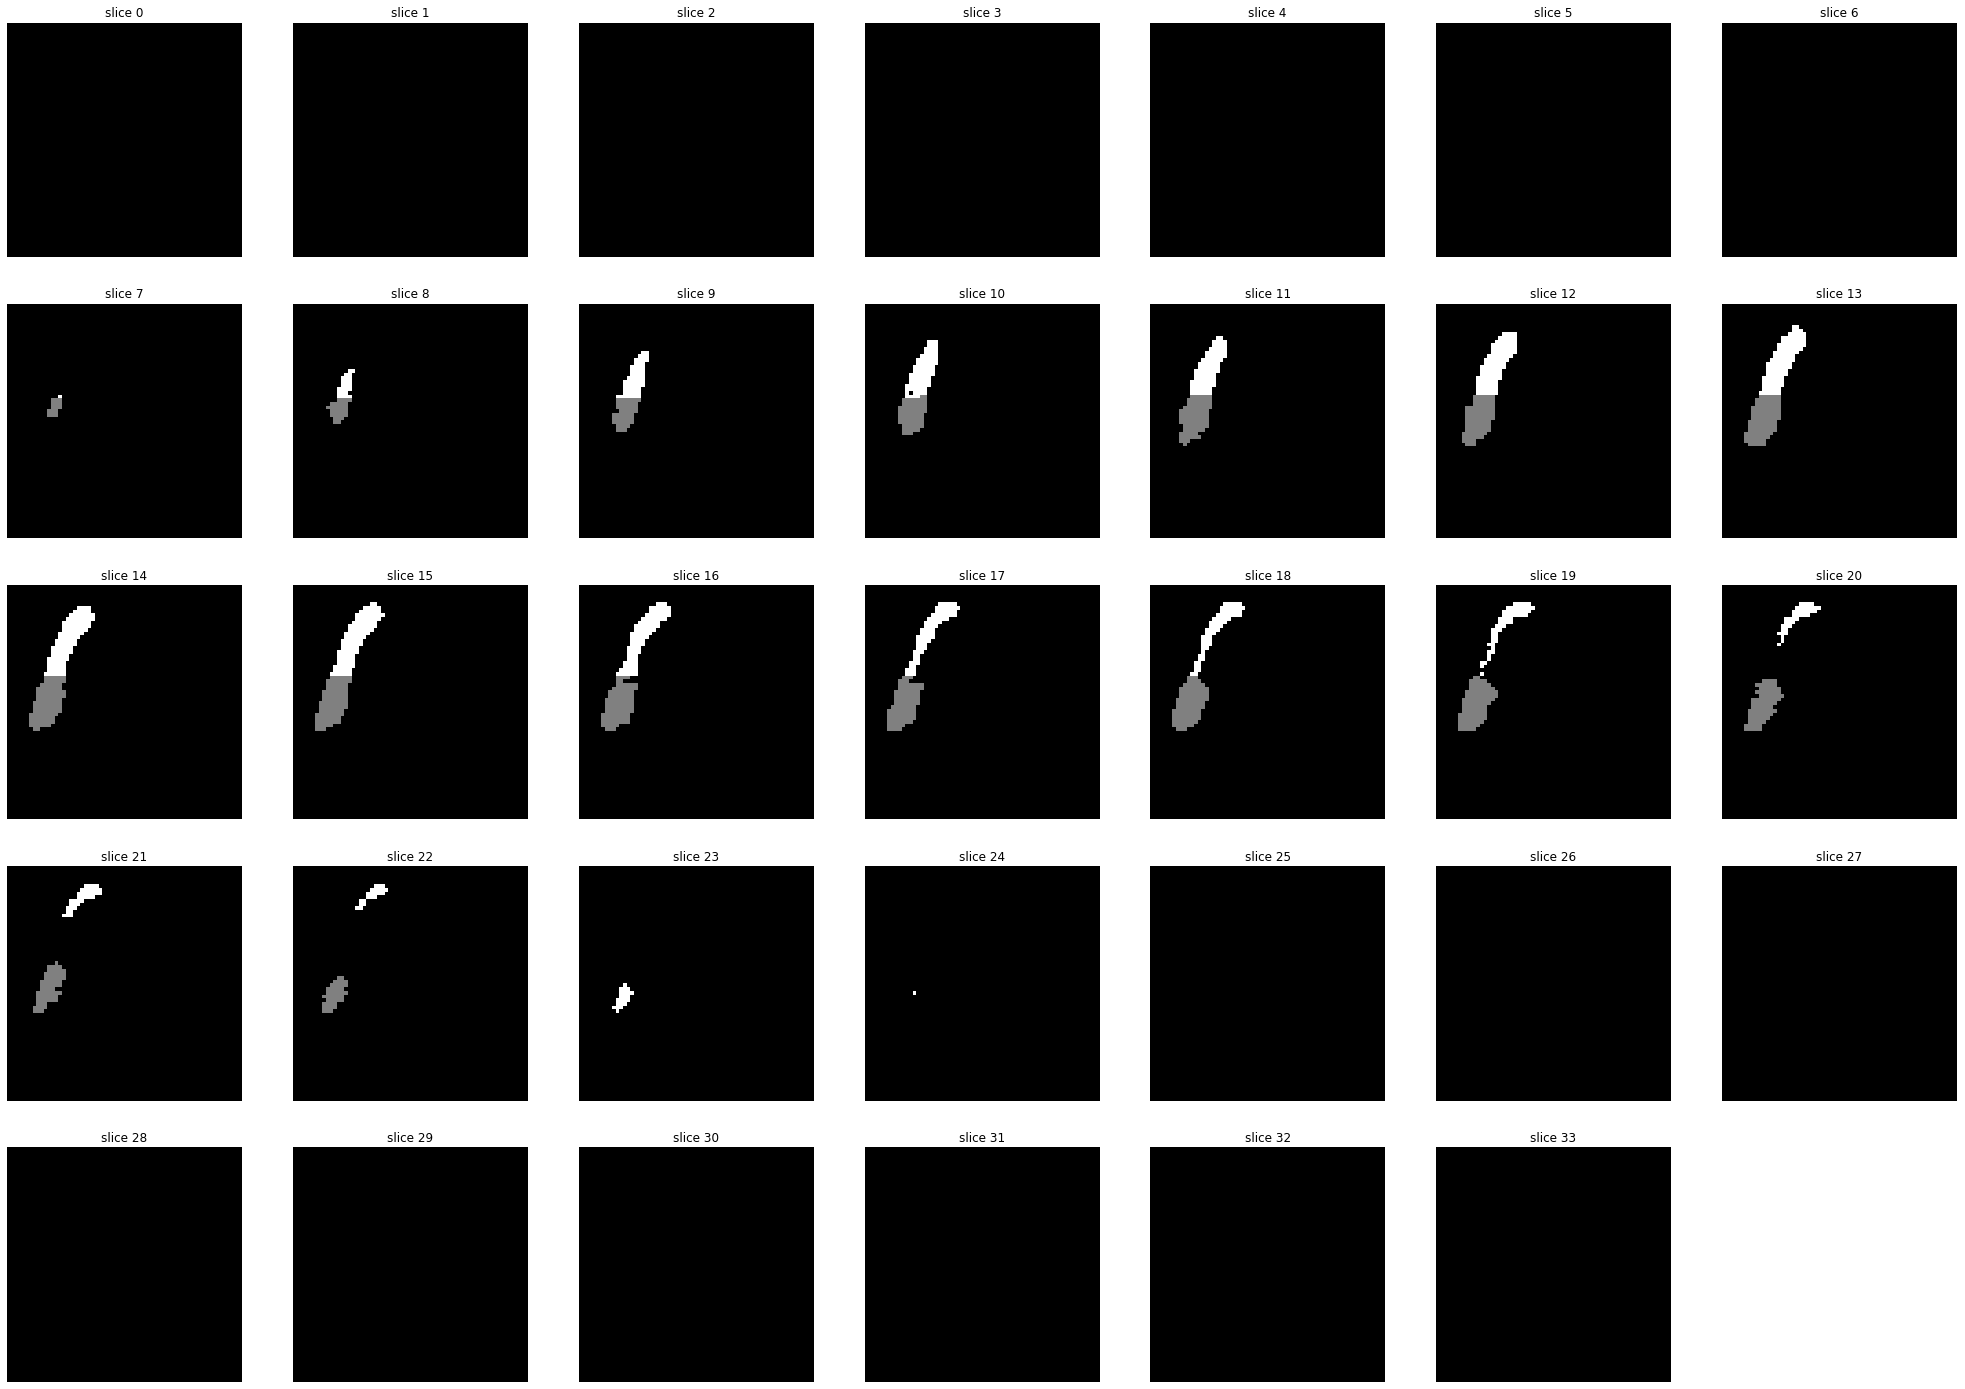

In [11]:
display_volume_slices(seg_5, 7, 5)

## SlicesDataset

In [12]:
class SlicesDataset(Dataset):
    """
    This class represents an indexable Torch dataset
    which could be consumed by the PyTorch DataLoader class
    """
    def __init__(self, data):
        self.data = data

        self.slices = []

        for i, d in enumerate(data):
            for j in range(d["image"].shape[0]):
                self.slices.append((i, j))

    def __getitem__(self, idx):
        """
        This method is called by PyTorch DataLoader class to return a sample with id idx

        Arguments: 
            idx {int} -- id of sample

        Returns:
            Dictionary of 2 Torch Tensors of dimensions [1, W, H]
        """
        slc = self.slices[idx]
        sample = dict()
        sample["id"] = idx
        
        # create two new keys in the "sample" dictionary, "image" and "seg"
        i, j = slc
        sample['image'] = torch.from_numpy(self.data[i]['image'][j, :, :][None, :]).type(torch.FloatTensor)
        sample['seg'] = torch.from_numpy(self.data[i]['seg'][j, :, :][None, :])

        return sample

    def __len__(self):
        """
        This method is called by PyTorch DataLoader class to return number of samples in the dataset

        Returns:
            int
        """
        return len(self.slices)

In [13]:
split = dict()
n = len(data)
split['train'], split['val'], split['test'] = np.split(list(range(n)),[int(n * 0.7),int(n * 0.85)]) 

In [14]:
data.shape, data[split["train"]].shape, data[split["test"]].shape, data[split["val"]].shape

((260,), (182,), (39,), (39,))

In [15]:
data_slice = SlicesDataset(data[split["train"]])
data_slice.__len__()

6448

In [16]:
len(data_slice.slices), data_slice.slices[-32:]

(6448,
 [(181, 0),
  (181, 1),
  (181, 2),
  (181, 3),
  (181, 4),
  (181, 5),
  (181, 6),
  (181, 7),
  (181, 8),
  (181, 9),
  (181, 10),
  (181, 11),
  (181, 12),
  (181, 13),
  (181, 14),
  (181, 15),
  (181, 16),
  (181, 17),
  (181, 18),
  (181, 19),
  (181, 20),
  (181, 21),
  (181, 22),
  (181, 23),
  (181, 24),
  (181, 25),
  (181, 26),
  (181, 27),
  (181, 28),
  (181, 29),
  (181, 30),
  (181, 31)])

In [17]:
slice_6432 = data_slice.__getitem__(6432)
slice_6432['image'].shape, slice_6432['seg'].shape

(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

In [18]:
slice_6432['image'].mean(), slice_6432['image'].max(), slice_6432['image'].min()

(tensor(0.1287), tensor(0.5861), tensor(0.))

In [19]:
(slice_6432['seg'] > 0).sum(), slice_6432['seg'].sum()

(tensor(197), tensor(276))

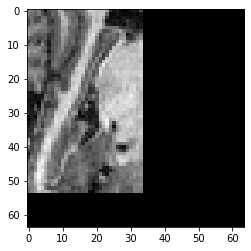

In [20]:
plt.imshow(slice_6432['image'][0], cmap='gray')

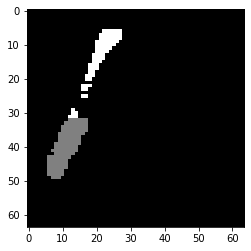

In [21]:
plt.imshow(slice_6432['seg'][0], cmap='gray')

## RecursiveUNet

In [22]:
class UNet(nn.Module):
    def __init__(self, num_classes=3, in_channels=1, initial_filter_size=64, kernel_size=3, num_downs=4, norm_layer=nn.InstanceNorm2d):
        # norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UNet, self).__init__()

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(in_channels=initial_filter_size * 2 ** (num_downs-1), out_channels=initial_filter_size * 2 ** num_downs,
                                             num_classes=num_classes, kernel_size=kernel_size, norm_layer=norm_layer, innermost=True)
        for i in range(1, num_downs):
            unet_block = UnetSkipConnectionBlock(in_channels=initial_filter_size * 2 ** (num_downs-(i+1)),
                                                 out_channels=initial_filter_size * 2 ** (num_downs-i),
                                                 num_classes=num_classes, kernel_size=kernel_size, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(in_channels=in_channels, out_channels=initial_filter_size,
                                             num_classes=num_classes, kernel_size=kernel_size, submodule=unet_block, norm_layer=norm_layer,
                                             outermost=True)

        self.model = unet_block

    def forward(self, x):
        return self.model(x)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, in_channels=None, out_channels=None, num_classes=1, kernel_size=3,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.InstanceNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        # downconv
        pool = nn.MaxPool2d(2, stride=2)
        conv1 = self.contract(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, norm_layer=norm_layer)
        conv2 = self.contract(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, norm_layer=norm_layer)

        # upconv
        conv3 = self.expand(in_channels=out_channels*2, out_channels=out_channels, kernel_size=kernel_size)
        conv4 = self.expand(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size)

        if outermost:
            final = nn.Conv2d(out_channels, num_classes, kernel_size=1)
            down = [conv1, conv2]
            up = [conv3, conv4, final]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(in_channels*2, in_channels,
                                        kernel_size=2, stride=2)
            model = [pool, conv1, conv2, upconv]
        else:
            upconv = nn.ConvTranspose2d(in_channels*2, in_channels, kernel_size=2, stride=2)

            down = [pool, conv1, conv2]
            up = [conv3, conv4, upconv]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    @staticmethod
    def contract(in_channels, out_channels, kernel_size=3, norm_layer=nn.InstanceNorm2d):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            norm_layer(out_channels),
            nn.LeakyReLU(inplace=True))
        return layer

    @staticmethod
    def expand(in_channels, out_channels, kernel_size=3):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        return layer

    @staticmethod
    def center_crop(layer, target_width, target_height):
        batch_size, n_channels, layer_width, layer_height = layer.size()
        xy1 = (layer_width - target_width) // 2
        xy2 = (layer_height - target_height) // 2
        return layer[:, :, xy1:(xy1 + target_width), xy2:(xy2 + target_height)]

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            crop = self.center_crop(self.model(x), x.size()[2], x.size()[3])
            return torch.cat([x, crop], 1)

In [23]:
unet = UNet()

In [24]:
train_data = DataLoader(SlicesDataset(data[split["train"]]),batch_size=8, shuffle=True, num_workers=0)
for x in train_data:
    batch = x
    break
slice_tensor = batch['image']
target = batch['seg']
slice_tensor.shape, target.shape

(torch.Size([8, 1, 64, 64]), torch.Size([8, 1, 64, 64]))

In [25]:
target[:, 0, :, :].shape

torch.Size([8, 64, 64])

In [26]:
prediction = unet(slice_tensor)
print(prediction.shape)
prediction[0, :, :, :]

torch.Size([8, 3, 64, 64])


tensor([[[-0.1213, -0.0986, -0.0741,  ..., -0.0724, -0.0692, -0.0736],
         [-0.0702, -0.0477, -0.0552,  ..., -0.0660, -0.0457, -0.0640],
         [-0.1051, -0.0639, -0.0610,  ..., -0.0619, -0.0470, -0.0657],
         ...,
         [-0.0833, -0.0573, -0.0543,  ..., -0.0541, -0.0413, -0.0648],
         [-0.0980, -0.0712, -0.0824,  ..., -0.0782, -0.0593, -0.0617],
         [-0.0807, -0.0631, -0.0696,  ..., -0.0651, -0.0521, -0.0626]],

        [[-0.0155,  0.0022, -0.0326,  ..., -0.0340, -0.0302, -0.0291],
         [-0.0353, -0.0212, -0.0069,  ..., -0.0214, -0.0408, -0.0323],
         [-0.0510, -0.0076, -0.0173,  ..., -0.0157, -0.0182, -0.0210],
         ...,
         [-0.0164, -0.0322, -0.0293,  ..., -0.0258, -0.0273, -0.0130],
         [-0.0106, -0.0008, -0.0078,  ..., -0.0007, -0.0007, -0.0077],
         [-0.0140, -0.0194, -0.0178,  ..., -0.0142, -0.0156, -0.0160]],

        [[ 0.0862,  0.0833,  0.0881,  ...,  0.1067,  0.0967,  0.1098],
         [ 0.0306,  0.0639,  0.1279,  ...,  0

In [27]:
prediction_softmax = F.softmax(prediction, dim=1)
print(prediction_softmax.shape)
prediction_softmax[0, :, :, :]

torch.Size([8, 3, 64, 64])


tensor([[[0.2992, 0.3025, 0.3107,  ..., 0.3091, 0.3105, 0.3080],
         [0.3183, 0.3180, 0.3076,  ..., 0.3097, 0.3159, 0.3131],
         [0.3082, 0.3131, 0.3130,  ..., 0.3085, 0.3131, 0.3109],
         ...,
         [0.3038, 0.3128, 0.3118,  ..., 0.3096, 0.3149, 0.3090],
         [0.2998, 0.3059, 0.3033,  ..., 0.3036, 0.3077, 0.3105],
         [0.3046, 0.3100, 0.3087,  ..., 0.3083, 0.3127, 0.3105]],

        [[0.3326, 0.3346, 0.3239,  ..., 0.3212, 0.3229, 0.3220],
         [0.3296, 0.3265, 0.3229,  ..., 0.3238, 0.3175, 0.3232],
         [0.3253, 0.3312, 0.3270,  ..., 0.3231, 0.3223, 0.3251],
         ...,
         [0.3249, 0.3208, 0.3197,  ..., 0.3185, 0.3193, 0.3255],
         [0.3272, 0.3282, 0.3269,  ..., 0.3281, 0.3262, 0.3277],
         [0.3256, 0.3238, 0.3251,  ..., 0.3244, 0.3243, 0.3254]],

        [[0.3682, 0.3629, 0.3654,  ..., 0.3697, 0.3666, 0.3700],
         [0.3521, 0.3555, 0.3695,  ..., 0.3665, 0.3666, 0.3637],
         [0.3665, 0.3557, 0.3600,  ..., 0.3685, 0.3646, 0.

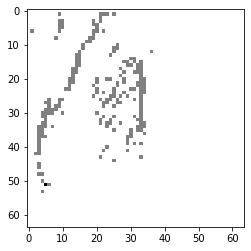

In [28]:
plt.imshow(torch.argmax(np.squeeze(prediction[0, :, :, :].cpu().detach()), dim=0), cmap='gray')

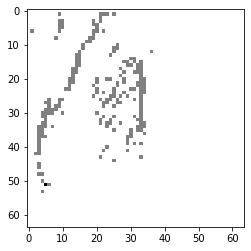

In [29]:
plt.imshow(torch.argmax(np.squeeze(prediction_softmax[0, :, :, :].cpu().detach()), dim=0), cmap='gray')

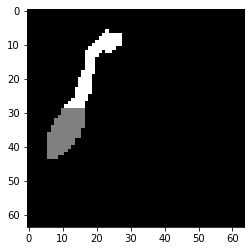

In [30]:
plt.imshow(target[0, 0, :, :], cmap='gray')

In [31]:
loss = torch.nn.CrossEntropyLoss()(prediction_softmax, target[:, 0, :, :])
loss

tensor(1.1229, grad_fn=<NllLoss2DBackward>)

## UNetInferenceAgent

In [32]:
class UNetInferenceAgent:
    """
    Stores model and parameters and some methods to handle inferencing
    """
    def __init__(self, parameter_file_path='', model=None, device="cpu", patch_size=64):

        self.model = model
        self.patch_size = patch_size
        self.device = device

        if model is None:
            self.model = UNet(num_classes=3)

        if parameter_file_path:
            self.model.load_state_dict(torch.load(parameter_file_path, map_location=self.device))

        self.model.to(device)

    def single_volume_inference(self, volume):
        """
        Runs inference on a single volume of conformant patch size

        Arguments:
            volume {Numpy array} -- 3D array representing the volume

        Returns:
            3D NumPy array with prediction mask
        """
        self.model.eval()

        # volume is a numpy array of shape [X,Y,Z] and I will slice X axis
        slices = []

        # create mask for each slice across the X (0th) dimension. 
        # put all slices into a 3D Numpy array

        for ix in range(0, volume.shape[0]):
#             img = volume[ix,:,:]
#             slc = img.astype(np.single)/np.max(img)
#             slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(self.device)
            slice_tensor = torch.from_numpy(volume[ix,:,:].astype(np.single)).unsqueeze(0).unsqueeze(0)
            pred = self.model(slice_tensor.to(self.device))
            mask = torch.argmax(np.squeeze(pred.cpu().detach()), dim=0)
            slices.append(mask)
        return np.dstack(slices).transpose(2, 0, 1)


    
    def single_volume_inference_unpadded(self, volume, patch_size):
        """
        Runs inference on a single volume of arbitrary patch size,
        padding it to the conformant size first

        Arguments:
            volume {Numpy array} -- 3D array representing the volume

        Returns:
            3D NumPy array with prediction mask
        """
        
        volume = med_reshape(volume, (volume.shape[0], patch_size, patch_size))
        
        return single_volume_inference(self, volume)

## UNetExperiment

In [33]:
def display_volume_slices(img, w, h):
    plot_w = w
    plot_h = h

    # You can play with figsize parameter to adjust how large the images are
    fig, ax = plt.subplots(plot_h, plot_w, figsize=[35,25])

    for i in range(plot_w*plot_h):
        plt_x = i % plot_w
        plt_y = i // plot_w
        if (i < len(img)):
            ax[plt_y, plt_x].set_title(f"slice {i}")
            ax[plt_y, plt_x].imshow(img[i,0, :, :], cmap='gray')
        ax[plt_y, plt_x].axis("off")

    plt.show()

In [34]:
class UNetExperiment:
    """
    This class implements the basic life cycle for a segmentation task with UNet(https://arxiv.org/abs/1505.04597).
    The basic life cycle of a UNetExperiment is:

        run():
            for epoch in n_epochs:
                train()
                validate()
        test()
    """
    def __init__(self, config, split, dataset):
        self.n_epochs = config.n_epochs
        self.split = split
        self._time_start = ""
        self._time_end = ""
        self.epoch =1
        self.name = config.name

        # Create output folders
        dirname = f'{time.strftime("%Y-%m-%d_%H%M", time.gmtime())}_{self.name}'
        self.out_dir = os.path.join(config.test_results_dir, dirname)
        os.makedirs(self.out_dir, exist_ok=True)

        # Create data loaders
        self.train_loader = DataLoader(SlicesDataset(dataset[split["train"]]),
                batch_size=config.batch_size, shuffle=True, num_workers=0)
        self.val_loader = DataLoader(SlicesDataset(dataset[split["val"]]),
                batch_size=config.batch_size, shuffle=True, num_workers=0)

        # access volumes directly for testing
        self.test_data = dataset[split["test"]]

        if not torch.cuda.is_available():
            print("WARNING: No CUDA device is found. This may take significantly longer!")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # use a recursive UNet model from German Cancer Research Center, Division of Medical Image Computing
        self.model = UNet()
        self.model.to(self.device)

        # use a standard cross-entropy loss since the model output is essentially
        # a tensor with softmax prediction of each pixel's probability of belonging to a certain class
        self.loss_function = torch.nn.CrossEntropyLoss()

        # use standard SGD method to optimize the weights
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)
        
        # Scheduler helps to update learning rate automatically
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')

        # Set up Tensorboard. By default it saves data into runs folder. You need to launch
        self.tensorboard_train_writer = SummaryWriter(comment="_train")
        self.tensorboard_val_writer = SummaryWriter(comment="_val")

    def train(self):
        """
        This method is executed once per epoch and takes 
        care of model weight update cycle
        """
        print(f"Training epoch {self.epoch}...")
        self.model.train()

        # Loop over the minibatches
        for i, batch in enumerate(self.train_loader):
            self.optimizer.zero_grad()

            # Feed data to the model and feed target to the loss function
#             display_volume_slices(batch['image'], 4, 2)
#             display_volume_slices(batch['seg'], 4, 2)            
            data = batch['image'].to(self.device)
            target = batch['seg'].to(self.device)
            
            prediction = self.model(data)
            prediction_softmax = F.softmax(prediction, dim=1)
            loss = self.loss_function(prediction_softmax, target[:, 0, :, :])

            # What does each dimension of variable prediction represent?
            # batch_size, 3 classes, coronal, axial

            loss.backward()
            self.optimizer.step()

            if (i % 10) == 0:
                # Output to console on every 10th batch
                print(f"\nEpoch: {self.epoch} Batch: {i} Train loss: {loss}, {100*(i+1)/len(self.train_loader):.1f}% complete")

                counter = 100*self.epoch + 100*(i/len(self.train_loader))

                log_to_tensorboard(
                    self.tensorboard_train_writer,
                    loss,
                    data,
                    target,
                    prediction_softmax,
                    prediction,
                    counter)

            print(".", end='')

        print("\nTraining complete")

    def validate(self):
        """
        This method runs validation cycle, using same metrics as 
        Train method. Note that model needs to be switched to eval
        mode and no_grad needs to be called so that gradients do not 
        propagate
        """
        print(f"Validating epoch {self.epoch}...")

        self.model.eval()
        loss_list = []

        with torch.no_grad():
            for i, batch in enumerate(self.val_loader):              
                data = batch['image'].to(self.device)
                target = batch['seg'].to(self.device)
                prediction = self.model(data)
                prediction_softmax = F.softmax(prediction, dim=1)
                loss = self.loss_function(prediction_softmax, target[:, 0, :, :])

                print(f"Batch {i}. Data shape {data.shape} Loss {loss}")

                loss_list.append(loss.item())

        self.scheduler.step(np.mean(loss_list))

        log_to_tensorboard(
            self.tensorboard_val_writer,
            np.mean(loss_list),
            data,
            target,
            prediction_softmax, 
            prediction,
            (self.epoch+1) * 100)
        print(f"Validation complete")

    def save_model_parameters(self):
        """
        Saves model parameters to a file in results directory
        """
        path = os.path.join(self.out_dir, "model.pth")

        torch.save(self.model.state_dict(), path)

    def load_model_parameters(self, path=''):
        """
        Loads model parameters from a supplied path or a
        results directory
        """
        if not path:
            model_path = os.path.join(self.out_dir, "model.pth")
        else:
            model_path = path

        if os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path))
        else:
            raise Exception(f"Could not find path {model_path}")

    def run_test(self):
        """
        This runs test cycle on the test dataset.
        Note that process and evaluations are quite different
        Here we are computing a lot more metrics and returning
        a dictionary that could later be persisted as JSON
        """
        print("Testing...")
        self.model.eval()

        inference_agent = UNetInferenceAgent(model=self.model, device=self.device)

        out_dict = {}
        out_dict["volume_stats"] = []
        dc_list = []
        jc_list = []

        # for every in test set
        for i, x in enumerate(self.test_data):
            pred_label = inference_agent.single_volume_inference(x["image"])

            dc = Dice3d(pred_label, x["seg"])
            jc = Jaccard3d(pred_label, x["seg"])
            dc_list.append(dc)
            jc_list.append(jc)


            out_dict["volume_stats"].append({
                "filename": x['filename'],
                "dice": dc,
                "jaccard": jc
                })
            print(f"{x['filename']} Dice {dc:.4f}. {100*(i+1)/len(self.test_data):.2f}% complete")

        out_dict["overall"] = {
            "mean_dice": np.mean(dc_list),
            "mean_jaccard": np.mean(jc_list)}

        print("\nTesting complete.")
        return out_dict

    def run(self):
        """
        Kicks off train cycle and writes model parameter file at the end
        """
        self._time_start = time.time()

        print("Experiment started.")

        # Iterate over epochs
        for self.epoch in range(self.n_epochs):
            self.train()
            self.validate()

        # save model for inferencing
        self.save_model_parameters()

        self._time_end = time.time()
        print(f"Run complete. Total time: {time.strftime('%H:%M:%S', time.gmtime(self._time_end - self._time_start))}")

In [35]:
class Config:
    """
    Holds configuration parameters
    """
    def __init__(self):
        self.name = "Basic_unet"
        self.root_dir = r"../data"
        self.n_epochs = 1
        self.learning_rate = 0.0002
        self.batch_size = 8
        self.patch_size = 64
        self.test_results_dir = "test_results"

if __name__ == "__main__":
    # Get configuration
    c = Config()

    # Load data
    print("Loading data...")

    data = LoadHippocampusData(c.root_dir, y_shape = c.patch_size, z_shape = c.patch_size)

    # create three keys in the dictionary ("train", "val" and "test") with each key storing the array with indices 
    split = dict()
    n = len(data)
    split['train'], split['val'], split['test'] = np.split(list(range(n)),[int(n * 0.7),int(n * 0.85)]) 

    # Set up and run experiment
    exp = UNetExperiment(c, split, data)

    # run training
    exp.run()

    # prep and run testing
    results_json = exp.run_test()

    results_json["config"] = vars(c)

    with open(os.path.join(exp.out_dir, "results.json"), 'w') as out_file:
        json.dump(results_json, out_file, indent=2, separators=(',', ': '))

Loading data...
Processed 260 files, total 9198 slices
Experiment started.
Training epoch 0...

Epoch: 0 Batch: 0 Train loss: 1.0895907878875732, 0.1% complete
..........
Epoch: 0 Batch: 10 Train loss: 0.5740869641304016, 1.4% complete
..........
Epoch: 0 Batch: 20 Train loss: 0.581321656703949, 2.6% complete
..........
Epoch: 0 Batch: 30 Train loss: 0.571891725063324, 3.8% complete
..........
Epoch: 0 Batch: 40 Train loss: 0.561088502407074, 5.1% complete
..........
Epoch: 0 Batch: 50 Train loss: 0.564659059047699, 6.3% complete
..........
Epoch: 0 Batch: 60 Train loss: 0.565788209438324, 7.6% complete
..........
Epoch: 0 Batch: 70 Train loss: 0.586387574672699, 8.8% complete
..........
Epoch: 0 Batch: 80 Train loss: 0.566429078578949, 10.0% complete
..........
Epoch: 0 Batch: 90 Train loss: 0.578971803188324, 11.3% complete
..........
Epoch: 0 Batch: 100 Train loss: 0.577873170375824, 12.5% complete
..........
Epoch: 0 Batch: 110 Train loss: 0.567100465297699, 13.8% complete
........

In [36]:
results_json

{'volume_stats': [{'filename': 'hippocampus_215.nii.gz',
   'dice': 0.0,
   'jaccard': 0.0},
  {'filename': 'hippocampus_288.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_212.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_287.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_366.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_277.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_244.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_175.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_156.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_133.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_236.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_302.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_343.nii.gz', 'dice': 0.0, 'jaccard': 0.0},
  {'filename': 'hippocampus_268.nii.gz', 'dice': 0.0, '

In [37]:
train_data = DataLoader(SlicesDataset(data[split["train"]]),batch_size=8, shuffle=True, num_workers=0)
for x in train_data:
    batch = x
    break
slice_tensor = batch['image']
target = batch['seg']
slice_tensor.shape, target.shape

(torch.Size([8, 1, 64, 64]), torch.Size([8, 1, 64, 64]))

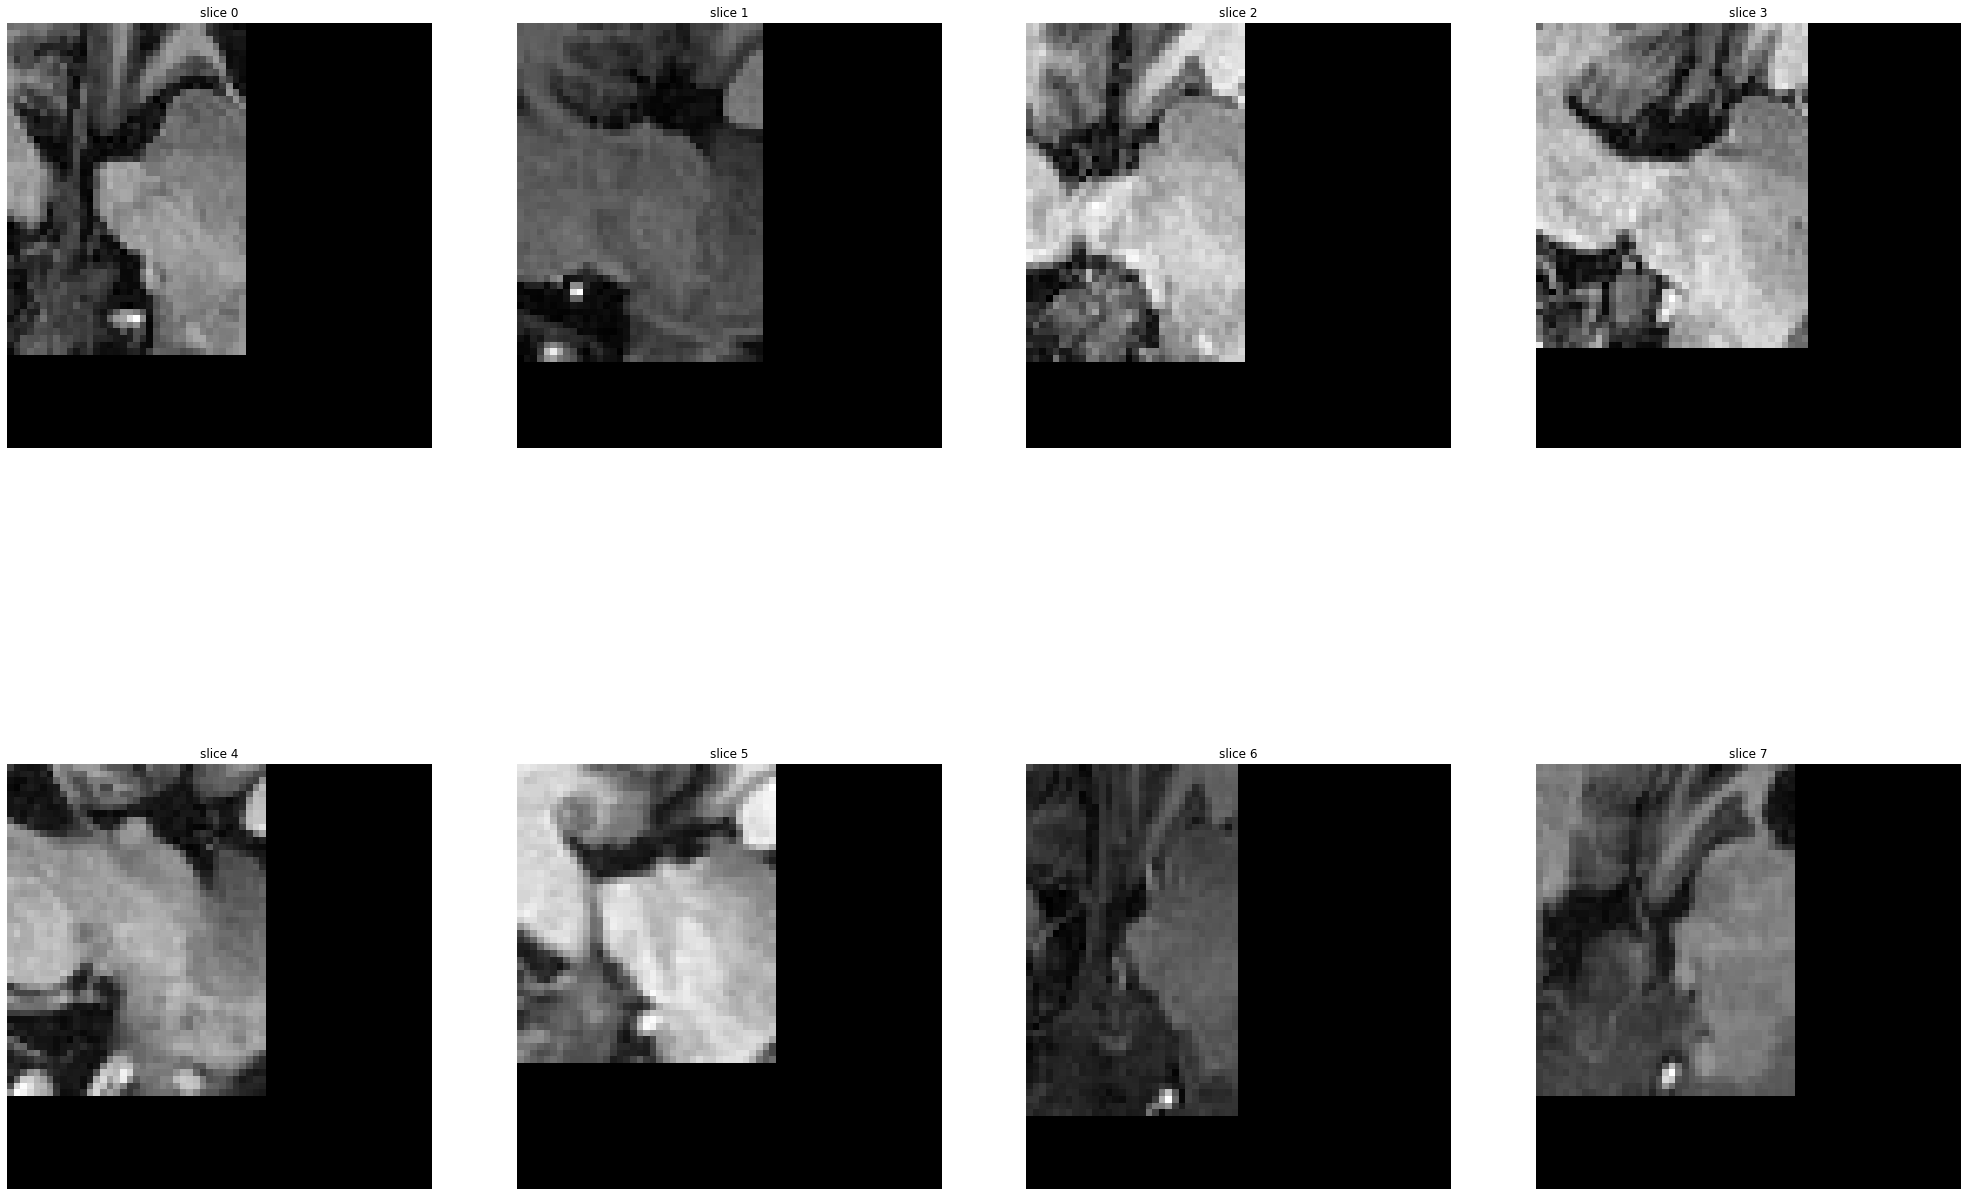

In [38]:
display_volume_slices(slice_tensor, 4, 2)

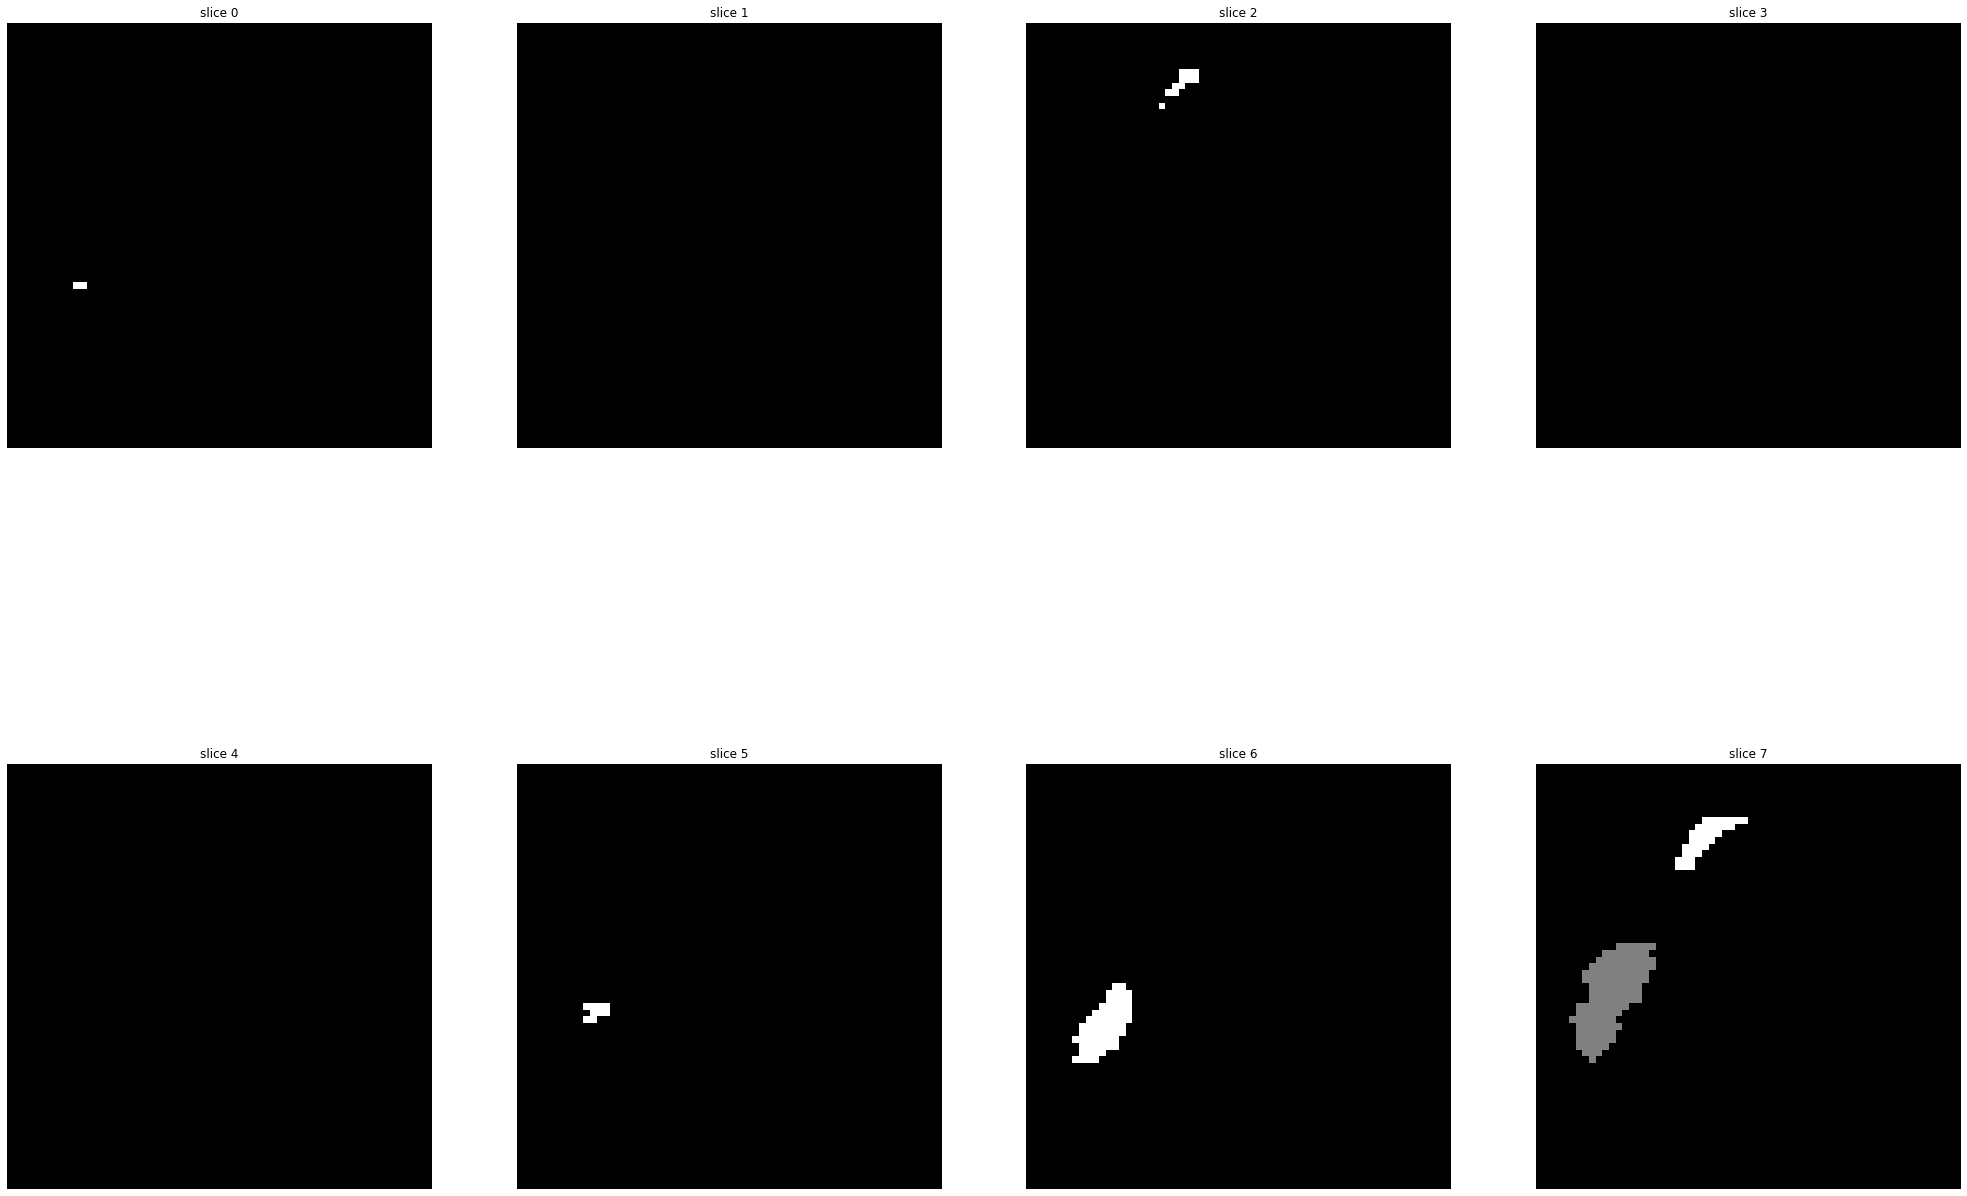

In [39]:
display_volume_slices(target, 4, 2)

In [40]:
target[:, 0, :, :].shape

torch.Size([8, 64, 64])

In [41]:
prediction = exp.model(slice_tensor.to(exp.device))
print(prediction.shape)
prediction[2, :, :, :]

torch.Size([8, 3, 64, 64])


tensor([[[ 1860.7587,  3355.6375,  4618.4438,  ...,  2813.6484,
           2067.5654,  1148.4395],
         [ 3280.7698,  5768.7441,  7937.6499,  ...,  4742.1504,
           3441.7883,  1975.1414],
         [ 4451.7036,  7893.3369, 10858.7402,  ...,  6545.1147,
           4866.2734,  2702.7051],
         ...,
         [ 3160.2329,  5414.0815,  7553.9170,  ...,  6207.5073,
           4660.4150,  2563.8533],
         [ 2260.0605,  3893.9902,  5417.3530,  ...,  4499.1748,
           3364.4746,  1836.8099],
         [ 1234.9374,  2122.7783,  2960.3694,  ...,  2343.6804,
           1819.4269,   950.5674]],

        [[ -895.8956, -1459.9467, -1815.6479,  ...,  -960.5831,
           -689.6276,  -319.8068],
         [-1595.0975, -2361.7510, -3192.0750,  ..., -1705.7024,
          -1130.2987,  -576.5983],
         [-1910.5831, -3286.5730, -4173.8223,  ..., -2348.2490,
          -1651.2507,  -785.3725],
         ...,
         [-1350.2391, -2056.4209, -2931.4016,  ..., -2308.3672,
          -1595

In [42]:
prediction_softmax = F.softmax(prediction, dim=1)
print(prediction_softmax.shape)
prediction_softmax[2, :, :, :]

torch.Size([8, 3, 64, 64])


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [43]:
mask = torch.argmax(np.squeeze(prediction_softmax.cpu().detach()), dim=1).unsqueeze(1)
mask.shape

torch.Size([8, 1, 64, 64])

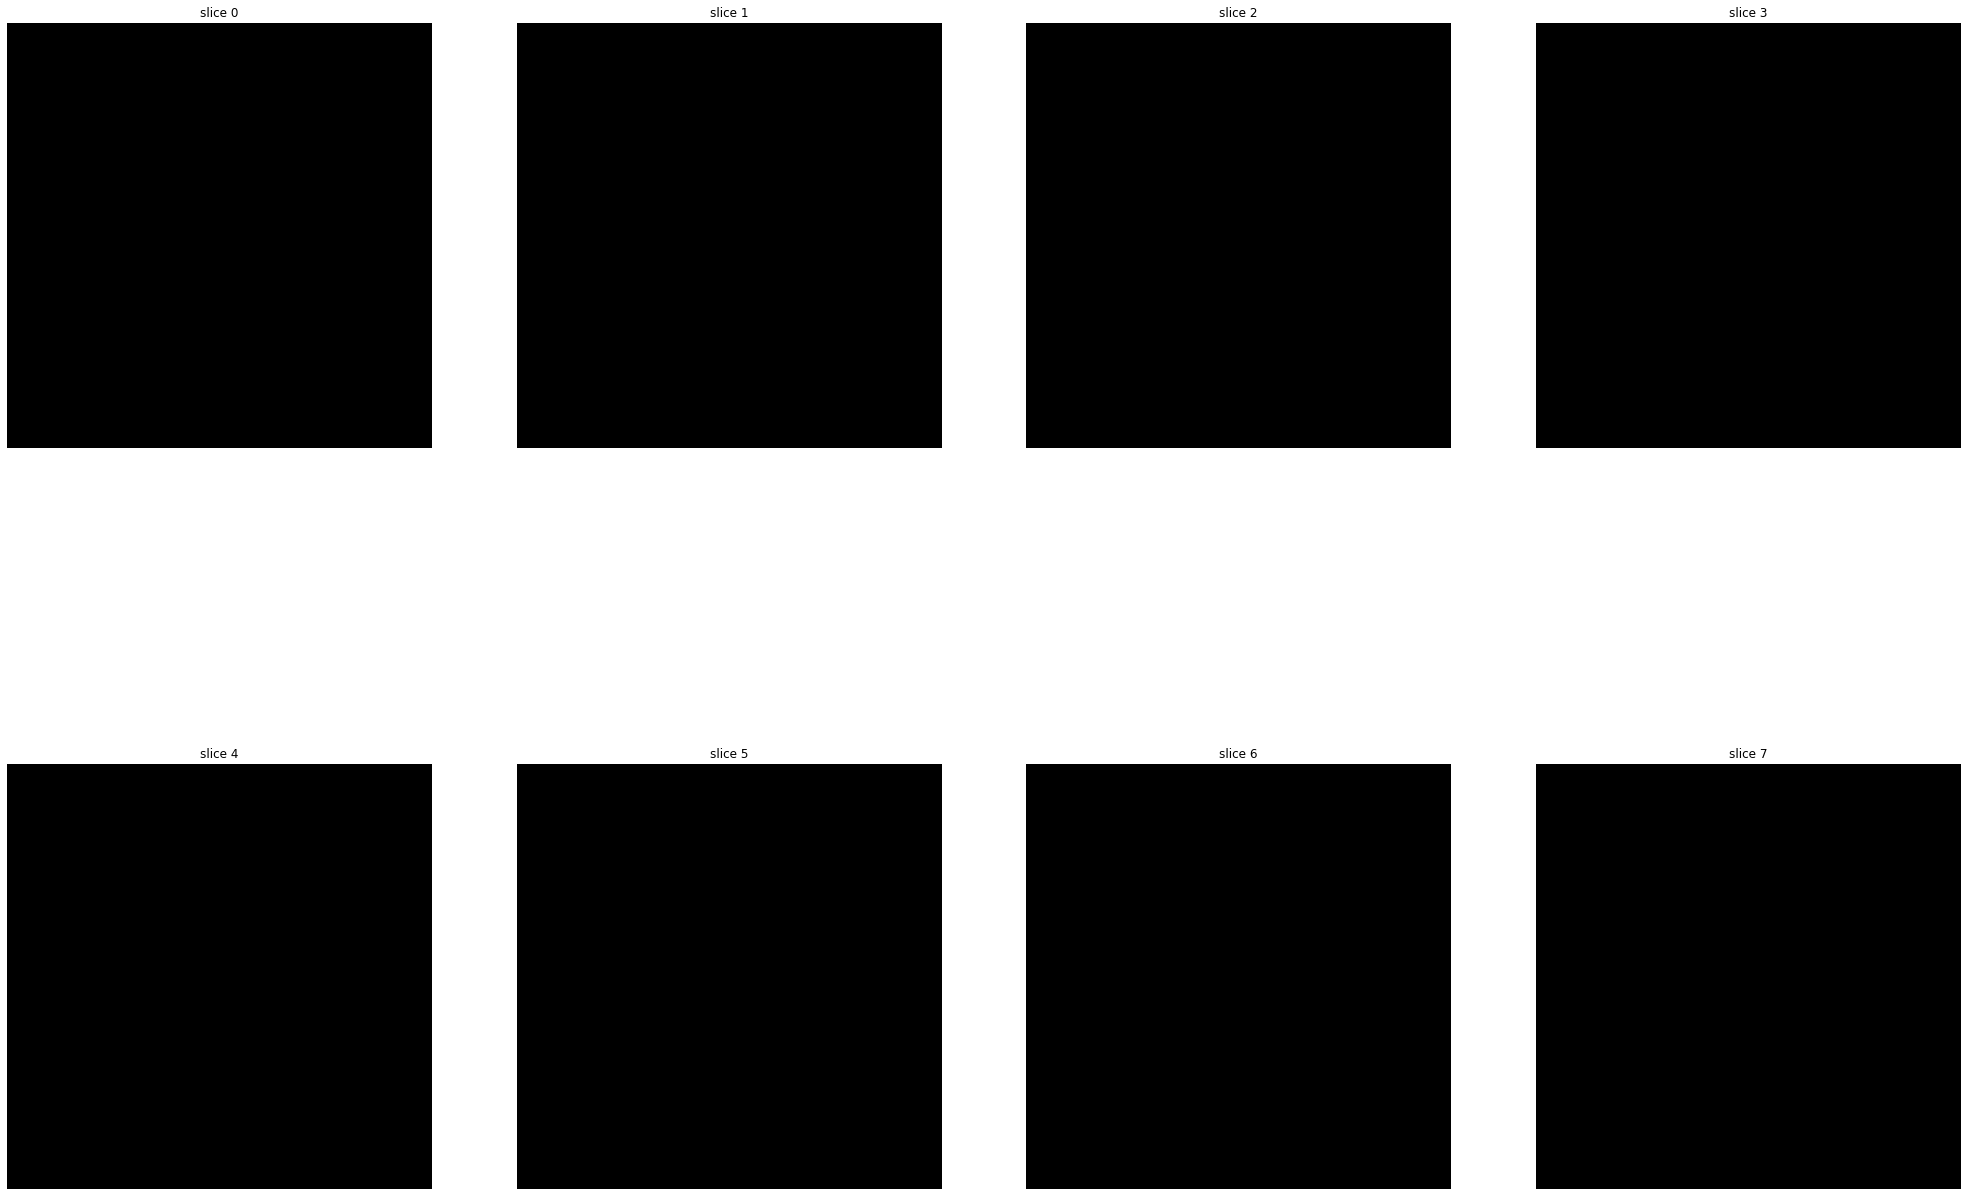

In [44]:
display_volume_slices(mask, 4, 2)

In [45]:
loss = torch.nn.CrossEntropyLoss()(prediction_softmax, target[:, 0, :, :].to(exp.device))
loss

tensor(0.5590, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [46]:
for x in exp.train_loader:
    y = np.squeeze(x['image'][0, :, :])
    print(y.max())
    break

tensor(0.4127)


In [47]:
exp.model.eval()

# volume is a numpy array of shape [X,Y,Z] and I will slice X axis
slices = []

# create mask for each slice across the X (0th) dimension. 
# put all slices into a 3D Numpy array
# volume = exp.test_data[0]['image']
volume = exp.test_data[0]['image']
img = volume[0,:,:]
print('img', img.shape, img)
z = np.squeeze(img)
print(z.shape)
print(z.max())
# slc = img.astype(np.single)/np.max(img)
# print('slc', slc.shape, slc)
# slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(exp.device)
# print('slc_tensor', slc_tensor.shape, slc_tensor)
slc_tensor = torch.from_numpy(volume[0,:,:].astype(np.single)).unsqueeze(0).unsqueeze(0).to(exp.device)
pred = exp.model(slc_tensor)
print('pred', pred.shape, pred)
mask = torch.argmax(np.squeeze(pred.cpu().detach()), dim=0)
print('mask', mask.shape, mask)
print((mask>0).sum())

img (64, 64) [[0.10071941 0.23741005 0.35971221 ... 0.         0.         0.        ]
 [0.08633094 0.26618704 0.38129497 ... 0.         0.         0.        ]
 [0.10791367 0.33093524 0.37410071 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(64, 64)
0.9784172773361206
pred torch.Size([1, 3, 64, 64]) tensor([[[[ 1823.6031,  3289.7100,  4532.3101,  ...,  2717.1021,
            1996.5980,  1109.0364],
          [ 3214.9180,  5655.1133,  7789.3525,  ...,  4578.9478,
            3323.3208,  1907.1725],
          [ 4361.3560,  7735.6099, 10652.7080,  ...,  6317.1436,
            4696.7920,  2608.6370],
          ...,
          [ 3144.2314,  5388.7954,  7527.7822,  ...,  5918.6973,
            4441.8257,  2443.2725],
          [ 2247.3213,  3873.4080,  5395.4790,  ...,  4289.4302,

In [48]:
s = exp.test_data[0]['seg']
for x in exp.test_data:
    print((x['seg']>0).sum() / (x['seg']==0).sum())

0.023802552364901055
0.02532888019340856
0.025626350355563824
0.025025025025025027
0.02696292682265726
0.025056118425043985
0.021044345316189976
0.020682780961873908
0.025025025025025027
0.021805737678702787
0.020806530920161926
0.02764078449363459
0.020380836719759602
0.022421261287717494
0.02654436352960552
0.01798836600077918
0.02809770370476614
0.019213826961229363
0.024695328973231834
0.023751374666152507
0.02490844157321262
0.024658709170180832
0.026301848431482037
0.017633098181770633
0.02033484981579327
0.02530861757769785
0.02232145868607624
0.026187775326564272
0.025619012870316715
0.024041515196562023
0.01893529222394568
0.025723785806702933
0.02219655322395488
0.020551992197788898
0.01955874033565906
0.019881840749096453
0.026669340284740325
0.026552122638225588
0.02014611467788355
